In [1]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Descomprimir el archivo ZIP
zip_path = r'frutas-360.zip'
extract_path = r'frutas-360'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Descompresión completada.")

Descompresión completada.


In [3]:
# Rutas de las imágenes de entrenamiento y prueba
train_dir = os.path.join(extract_path, 'frutas-360', 'Training')
test_dir = os.path.join(extract_path, 'frutas-360', 'Test')

In [4]:
# Configuración de parámetros
target_size = (100, 100)  # Tamaño de la imagen
batch_size = 32  # Tamaño del lote


In [5]:
# Preparar el generador de datos con un aumento de datos moderado
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalización
    rotation_range=20,  # Aumento de rotación
    width_shift_range=0.1,  # Desplazamiento horizontal
    height_shift_range=0.1,  # Desplazamiento vertical
    zoom_range=0.1,  # Zoom
    horizontal_flip=True,  # Volteo horizontal
    validation_split=0.2  # Validación en el 20% de los datos
)

In [6]:
# Generador para entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    subset='training',
    seed=42
)

Found 8698 images belonging to 24 classes.


In [7]:
# Generador para validación
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation',
    seed=42
)

Found 2166 images belonging to 24 classes.


In [48]:
# Crear modelo CNN simple para clasificación de imágenes
model = Sequential([
    Input(shape=(100, 100, 3)),  # Especificar la forma de entrada
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),  # Reducir sobreajuste

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),  # Reducir sobreajuste

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),  # Reducir sobreajuste

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Reducir sobreajuste
    Dense(train_generator.num_classes, activation='softmax')  # Salida con el número de clases
])


In [49]:
# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [50]:
# Usar EarlyStopping para evitar sobreajuste
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [51]:
# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=7,  # Pocas épocas por ahora, puede que se necesiten más
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/7


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


272/272 ━━━━━━━━━━━━━━━━━━━━ 83s 293ms/step - accuracy: 0.4307 - loss: 1.8376 - val_accuracy: 0.9501 - val_loss: 0.1452 - learning_rate: 0.0010
Epoch 2/7
272/272 ━━━━━━━━━━━━━━━━━━━━ 83s 303ms/step - accuracy: 0.9403 - loss: 0.1805 - val_accuracy: 0.9889 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 3/7
272/272 ━━━━━━━━━━━━━━━━━━━━ 90s 327ms/step - accuracy: 0.9765 - loss: 0.0710 - val_accuracy: 0.9691 - val_loss: 0.0934 - learning_rate: 0.0010
Epoch 4/7
272/272 ━━━━━━━━━━━━━━━━━━━━ 95s 348ms/step - accuracy: 0.9717 - loss: 0.0873 - val_accuracy: 0.9926 - val_loss: 0.0237 - learning_rate: 0.0010
Epoch 5/7
272/272 ━━━━━━━━━━━━━━━━━━━━ 92s 333ms/step - accuracy: 0.9888 - loss: 0.0360 - val_accuracy: 0.9940 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 6/7
272/272 ━━━━━━━━━━━━━━━━━━━━ 92s 335ms/step - accuracy: 0.9856 - loss: 0.0407 - val_accuracy: 0.9958 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 7/7
272/272 ━━━━━━━━━━━━━━━━━━━━ 87s 316ms/step - accuracy: 0.9860 - loss: 0.048

In [52]:
# Evaluación del modelo en el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalización de las imágenes de prueba
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Asegúrate de que esta ruta es correcta
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Pérdida en el conjunto de prueba: {test_loss}")
print(f"Precisión en el conjunto de prueba: {test_accuracy}")


Found 3631 images belonging to 24 classes.
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.9657 - loss: 0.2641
Pérdida en el conjunto de prueba: 0.2748579680919647
Precisión en el conjunto de prueba: 0.9630955457687378


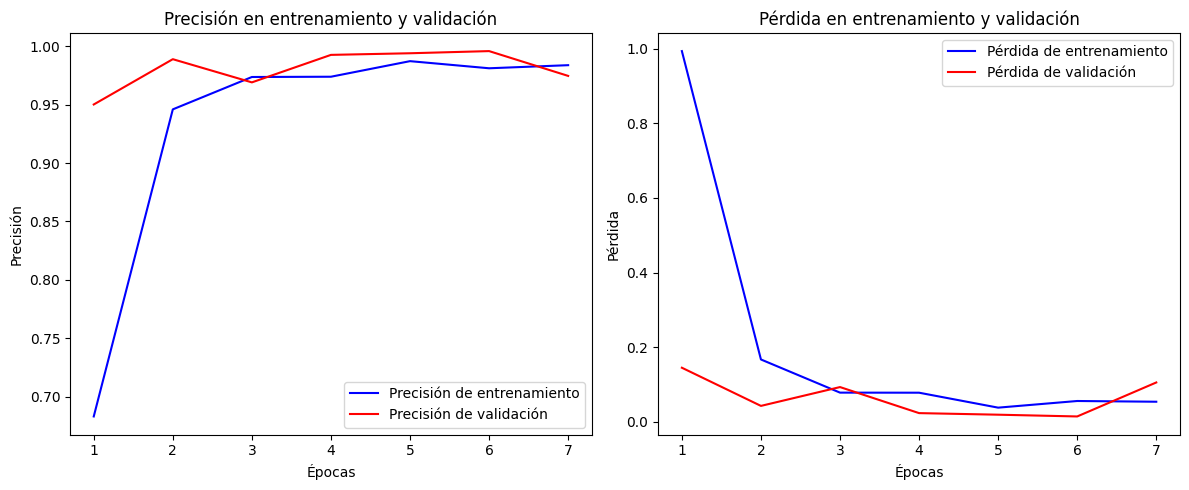

In [53]:
import matplotlib.pyplot as plt

# Obtener las métricas de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un rango de épocas
epochs = range(1, len(acc) + 1)

# Gráfico de precisión
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Precisión de entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Precisión de validación')
plt.title('Precisión en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida de validación')
plt.title('Pérdida en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()


In [55]:
model.save('modelo_entrenado.keras')